<a href="https://colab.research.google.com/github/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

First, set up the required Python modules and perform some general configuration.

(This part of the code follows the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb) that you should already be familiar with.)

Install the required Python packages using [pip](https://en.wikipedia.org/wiki/Pip):

* [`transformers`](https://huggingface.co/docs/transformers/index) is a popular deep learning package
* [`datasets`](https://huggingface.co/docs/datasets/) provides support for loading, creating, and manipulating datasets
* [`seqeval`](https://pypi.org/project/seqeval/) provides metrics for sequence labeling evaluation

Both of these packages are used extensively on this course.

In [1]:
!pip3 install -q transformers datasets seqeval

     |████████████████████████████████| 3.8 MB 12.9 MB/s 
     |████████████████████████████████| 325 kB 46.2 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 895 kB 33.2 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 6.5 MB 36.3 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
     |████████████████████████████████| 134 kB 56.8 MB/s 
     |████████████████████████████████| 1.1 MB 39.0 MB/s 
     |████████████████████████████████| 212 kB 38.4 MB/s 
     |████████████████████████████████| 127 kB 36.0 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 144 kB 19.4 MB/s 
     |████████████████████████████████| 271 kB 49.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 

(Above, the `!` at the start of the line tells the notebook to run the line as an operating system command rather than Python code, and the `-q` argument to `pip` runs the command in "quiet" mode, with less output.)

We'll also use the [`pprint`](https://docs.python.org/3/library/pprint.html) ("pretty-print") module to format output more readably below. The only difference to just using `print` is that some data structures will be easier to read and interpret.

In [2]:
from pprint import PrettyPrinter

pprint = PrettyPrinter(compact=True).pprint

Finally, we will reduce logging output. The `transformers` library by default produces fairly verbose logging. Commenting out the following code will enable low-priority output (`INFO` logging level and below).

In [3]:
import logging

logging.disable(logging.INFO)

---

# Download and prepare data

We will again use the `datasets` library function [`load_dataset`](https://huggingface.co/docs/datasets/master/en/package_reference/loading_methods#datasets.load_dataset) to load a dataset for our experiments.

In [4]:
import datasets


dataset = datasets.load_dataset("turku_ner_corpus")

Using custom data configuration default


Generating train split:   0%|          | 0/12217 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1364 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1555 [00:00<?, ? examples/s]

Dataset turku_ner_corpus downloaded and prepared to /root/.cache/huggingface/datasets/turku_ner_corpus/default/1.0.0/64d6e96666b88e03014617db39238ab6fbcaf5b22e6ab2180ff16bd39823ce95. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Let's see what the dataset contains:

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 12217
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1364
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1555
    })
})


The split to train, validation and test subsets, should look quite familiar by now, but this time we have `tokens` instead of `text` and `ner_tags` instead of the `labels` that were found in the text classification datasets.

Let's have a look at one example.

In [6]:
example = dataset["train"][10000]

pprint(example)

{'id': '10000',
 'ner_tags': [4, 10, 12, 12, 0, 6, 6, 12, 2, 12, 2, 12, 12, 12, 12, 12, 12],
 'tokens': ['Kevin', 'Ratcliffe', '(', 's.', '12.', 'marraskuuta', '1960', ',',
            'Mancot', ',', 'Wales', ')', 'on', 'walesilainen', 'entinen',
            'jalkapalloilija', '.']}


As we can see above, `tokens` are a sequence of word-like tokens, and `ner_tags` are numeric IDs. We can get the mapping of the latter feature to text strings as follows: 

In [7]:
tag_names = dataset["train"].features["ner_tags"].feature.names

pprint(tag_names)

['B-DATE', 'B-EVENT', 'B-LOC', 'B-ORG', 'B-PER', 'B-PRO', 'I-DATE', 'I-EVENT',
 'I-LOC', 'I-ORG', 'I-PER', 'I-PRO', 'O']


With that, we can have a look at the words and tag names for our example sentence:

In [8]:
for token, tag_id in zip(example["tokens"], example["ner_tags"]):
    print(f"{tag_id}\t{tag_names[tag_id]}\t{token}")

4	B-PER	Kevin
10	I-PER	Ratcliffe
12	O	(
12	O	s.
0	B-DATE	12.
6	I-DATE	marraskuuta
6	I-DATE	1960
12	O	,
2	B-LOC	Mancot
12	O	,
2	B-LOC	Wales
12	O	)
12	O	on
12	O	walesilainen
12	O	entinen
12	O	jalkapalloilija
12	O	.


IOB tagging such as this should be familiar to you from the intro course. If you'd like a refresher, you can review e.g. the [wikipedia article](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) on the topic.

---

# Tokenize and vectorize data

To tokenize and vectorize the texts of our dataset, we will again use previously created tokenizers through the simple [`AutoTokenizer`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) class.

The [`AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer.from_pretrained) function can load the tokenizer associated with any of the large number of models found in the [Hugging Face models repository](https://huggingface.co/models).

(**Note**: we're not actually using the BERT model here, just its tokenizer.) 

In [9]:
import transformers

model_name = "TurkuNLP/bert-base-finnish-cased-v1"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/414k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/796k [00:00<?, ?B/s]

We now have a tokenizer loaded, but there's a small complication: our data is already split into words. To support this case, the tokenizer can be given an argument `is_split_into_words=True`. Let's see how this works for our example:

In [10]:
pprint(tokenizer(example["tokens"], is_split_into_words=True))

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [102, 26456, 13366, 50052, 240, 46215, 348, 115, 111, 1426, 111,
               12925, 11934, 119, 4295, 3444, 50008, 119, 9112, 125, 308, 145,
               23791, 9235, 4456, 5263, 7749, 5367, 111, 103],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


Additionally, our tags are aligned to the original tokens: we have one tag for each token, where "token" is defined as in the source data. As the tokenizer may additionally split some of the source tokens, we'll need to re-align the tags when tokenizing.

We'll here use the function `word_ids` that the tokenizer provides for just this purpose:

In [11]:
tokenized = tokenizer(example["tokens"], is_split_into_words=True)

pprint(tokenized.word_ids())

[None, 0, 1, 1, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7, 8, 8, 8, 9, 10, 10, 11, 12, 13,
 13, 13, 14, 15, 15, 16, None]


Here the values in `word_ids` are `None` for special non-word symbols in the tokenizer output and integers giving the index of the original token for regular tokens. The latter can be used to look up the relevant label.

To perform the label realignment, we'll just use an implementation from the [transformers documentation](https://huggingface.co/docs/transformers/custom_datasets#tok_ner). (There's no need to understand this code in detail, but you should have an understanding of why we're doing this.)

In [12]:
def tokenize_and_align_labels(example):
    # adapted from https://huggingface.co/docs/transformers/custom_datasets#tok_ner
    tokenized = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    tags = example['ner_tags']
    word_ids = tokenized.word_ids()

    labels = []
    previous_word_idx = None
    for word_idx in word_ids:
        # Special tokens have word id None. Set their label to -100 so they
        # are automatically ignored in the loss function.
        if word_idx is None:
            labels.append(-100)
        # Set the label for the first token of each word normally.
        elif word_idx != previous_word_idx:
            labels.append(tags[word_idx])
        # For subsequent tokens in a word, set the label to -100.
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized["labels"] = labels
    return tokenized

We can then tokenize and vectorize our whole dataset by calling the [`Dataset.map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) function as usual.

In [13]:
# Apply the tokenizer to the whole dataset using .map()
dataset = dataset.map(tokenize_and_align_labels)

  0%|          | 0/12217 [00:00<?, ?ex/s]

  0%|          | 0/1364 [00:00<?, ?ex/s]

  0%|          | 0/1555 [00:00<?, ?ex/s]

---

# Build model

As usual, we will create a PyTorch model class with an `__init__()` function that creates the layers and a `forward()` function which implements the actual computation. For more information on these, please see the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html).

We're here building a simple RNN with the following structure:

* First, the token IDs are first mapped to embeddings of a user-specified size (`config.embedding_dim`) in a [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer. Note that here the embeddings are initialized randomly and learned along with other model weights. In real-world applications, the embeddings would typically be initialized with previously learned weights.
* Second, the embedded inputs are passed through an RNN ([torch.nn.RNN.html](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)), which produces a series of outputs ($(y_1, \ldots, y_n)$, where $n$ is the length of the input) and the final hidden state $h_n$. As we're assigning a label to each token, we'll use all of the outputs.
* Finally, there is a fully connected layer ([torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) that maps each of the RNN outputs to the possible output values of the classifier.

In the `forward` function we mostly just pass the input through the layers, with the following additional steps:

* To invoke the RNN, we need to provide the value of the initial hidden state $h_0$. Here we simply use [torch.zeros](https://pytorch.org/docs/stable/generated/torch.zeros.html) to create a tensor of the appropriate size filled with zeros.

Here's the model:

In [14]:
import torch


# This gives a new name to the config class, just for convenience
BasicConfig = transformers.PretrainedConfig


# This is the model
class SimpleRNN(transformers.PreTrainedModel):

    config_class = BasicConfig

    # In the initialization method, one instantiates the layers
    # these will be the parameters of the model
    def __init__(self, config):
        super().__init__(config)
        # Embedding layer: vocab size x embedding dim
        self.embeddings = torch.nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.embedding_dim
        )
        # RNN with configurable hidden size and nonlinearity
        self.rnn = torch.nn.RNN(
            input_size=config.embedding_dim,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            nonlinearity=config.nonlinearity,
            batch_first=True
        )
        # Output layer: embedding size to output size
        self.output_layer = torch.nn.Linear(
            in_features=config.hidden_size,
            out_features=config.num_labels
        )
        # Loss function: standard loss for classification
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, input_ids, labels=None, attention_mask=None):
        # Embed input ids
        x = self.embeddings(input_ids)
        # Run RNN repeatedly to get sequence of outputs and last hidden state
        rnn_outputs, h_n = self.rnn(x)
        # Map to outputs with fully connected layer
        output = self.output_layer(rnn_outputs)

        # Return value computed as previously:
        if labels is not None:
            # We have labels, so we can calculate the loss.
            # CrossEntropy output to have the shape
            # [batch_size, num_classes, other_dimensions];
            # we use `permute` to get that.
            return (self.loss(output.permute(0, 2, 1), labels), output)
        else:
            # No labels, so just return the output
            return (output,)

---

# Configure and train model

We'll first configure and instantiate the model. Here `vocab_size` should always be the vocabulary size of the tokenizer and `num_labels` the number of unique labels in the data (as here), but the others are hyperparameters that you can choose:

* `embedding_dim`: the size of the word (i.e. token) embeddings
* `hidden_size`: the size of the RNN hidden state vector _h_
* `num_layers`: number of stacked RNN layers
* `nonlinearity`: the non-linear function to apply in RNN (`'tanh'` or `'relu'`)

In [15]:
config = BasicConfig(
    vocab_size = tokenizer.vocab_size,
    num_labels = len(tag_names),
    embedding_dim = 32,
    hidden_size = 32,
    num_layers = 1,
    nonlinearity = "tanh",
)

model = SimpleRNN(config)

Training arguments are set similarly as in the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb). Many number of these settings relate to the frequency of evaluation and output during training, but the following are hyperparameters that you may wish to adjust:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per batch
* `max_steps`: the maximum number of steps to train for

In [16]:
# Set training arguments
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=500,
    logging_steps=500,
    learning_rate=0.001,
    per_device_train_batch_size=32,
    max_steps=5000,
)

We'll then define the metric to use. Here, we will use standard sequence evaluation metrics using `datasets.load_metric`.

In [17]:
metric = datasets.load_metric("seqeval")

def compute_metrics(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=2)

    # Remove ignored indices (special tokens)
    token_predictions = [
        [tag_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    token_labels = [
        [tag_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(
        predictions=token_predictions,
        references=token_labels
    )

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

We will here create a [DataCollatorForTokenClassification](https://huggingface.co/docs/transformers/main_classes/data_collator#transformers.DataCollatorForTokenClassification) to pad inputs to the same length (as required for batching). Note that this differs from the `DataCollatorWithPadding` class we used for text classification in that it also pads the sequence of labels.

As previously, we create an [EarlyStoppingCallback](https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback) to stop training when performance fails to improve for the given number of evaluations.

In [18]:
data_collator = transformers.DataCollatorForTokenClassification(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

Finally, as in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), we'll create a simple custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [19]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

We then pass the model, trainer arguments, training and evaluation data, metric, the collator, and the callbacks to a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) and call `.train()` to train the model.

In [20]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.605200,0.417715,0.000000,0.000000,0.000000,0.921565
1000,0.417900,0.366758,0.121212,0.015920,0.028144,0.925601
1500,0.353500,0.337274,0.259259,0.069652,0.109804,0.929399
2000,0.310700,0.321157,0.212302,0.106468,0.141816,0.929731
2500,0.277100,0.311819,0.221284,0.130348,0.164058,0.930586
3000,0.257800,0.304677,0.239291,0.161194,0.192628,0.930966
3500,0.242300,0.301071,0.244073,0.174129,0.203252,0.931678
4000,0.229500,0.299651,0.256991,0.192040,0.219818,0.932533
4500,0.224600,0.298391,0.240048,0.198010,0.217012,0.931393
5000,0.219700,0.297752,0.245614,0.195025,0.217415,0.931820


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score a

TrainOutput(global_step=5000, training_loss=0.31384068908691404, metrics={'train_runtime': 119.3588, 'train_samples_per_second': 1340.496, 'train_steps_per_second': 41.891, 'total_flos': 154875393288.0, 'train_loss': 0.31384068908691404, 'epoch': 13.09})

---

# Results

Evaluate and print out results:

In [21]:
eval_results = trainer.evaluate(dataset["test"])

pprint(eval_results)

print('F1:', eval_results['eval_f1'])

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 13.09,
 'eval_accuracy': 0.9318203399487228,
 'eval_f1': 0.21741541874653356,
 'eval_loss': 0.29775163531303406,
 'eval_precision': 0.24561403508771928,
 'eval_recall': 0.19502487562189055,
 'eval_runtime': 1.6523,
 'eval_samples_per_second': 941.094,
 'eval_steps_per_second': 118.015}
F1: 0.21741541874653356


Let's also have a look at training and evaluation loss and evaluation accuracy progression as we did in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb). (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

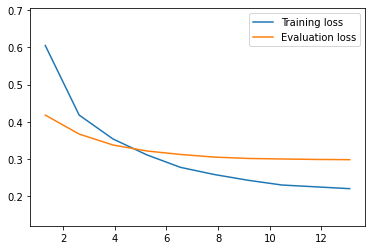

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

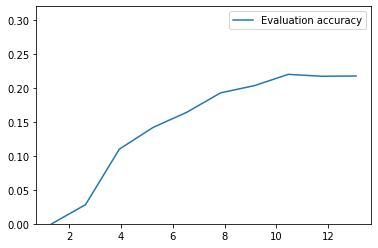

In [23]:
plot(training_logs.logs, ["eval_f1"], ["Evaluation accuracy"])

This is a fairly low starting point. Can you improve on the performance?